In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

from tqdm import tqdm
import warnings
from pprint import pprint

In [2]:
data = pd.read_csv("./data/augmented_data.csv")

In [3]:
data = data.dropna()
data = data[data["is_penalty"] == False]
data.replace([np.inf, -np.inf], 0, inplace=True)

In [4]:
data.nunique()

period                     4
minute                   125
possession               275
duration               76906
season_id                 41
match_id                3312
timestamp              81547
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       4
is_penalty                 1
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius        9
defenders_triangle        12
goalkeeper_x             258
goalkeeper_y  

In [5]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X_copy = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height", "season_id", "match_id", "timestamp", "team"], axis=1)
mutual_info = mutual_info_classif(X_copy, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_copy.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.042832
best_distance          0.038484
shooting_range         0.037675
location_x_distance    0.027037
defenders_triangle     0.021304
duration               0.017867
location_y_distance    0.012655
goalkeeper_x           0.011892
open_goal              0.011345
pass_length            0.011123
pass_duration          0.009904
good_foot              0.009195
first_time             0.006228
period                 0.005223
num_passes             0.004907
goalkeeper_y           0.004715
one_on_one             0.004704
shot_angle             0.003271
defenders_3m_radius    0.003145
was_leading            0.002763
pass_angle             0.002572
under_pressure         0.002015
game_state             0.001415
xg_so_far              0.001155
is_header              0.000340
is_penalty             0.000252
follows_dribble        0.000171
possession             0.000091
minute                 0.000000
aerial_won             0.000000
shots_so_far           0.000000
dtype: f

In [6]:
data.nunique()

period                     4
minute                   125
possession               275
duration               76906
season_id                 41
match_id                3312
timestamp              81547
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       4
is_penalty                 1
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius        9
defenders_triangle        12
goalkeeper_x             258
goalkeeper_y  

In [7]:
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height", "season_id", "match_id", "timestamp", "team"], axis=1)
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]

In [8]:
X, y2 = SMOTE(sampling_strategy=0.36).fit_resample(X, y2)

In [9]:
chi = []
for column in ["is_penalty", "first_time", "open_goal", "one_on_one", "good_foot", "under_pressure", "defenders_3m_radius", "defenders_triangle"]:
    contingency_table = pd.crosstab(X[column], y2)
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi.append((column, chi2, p, dof))

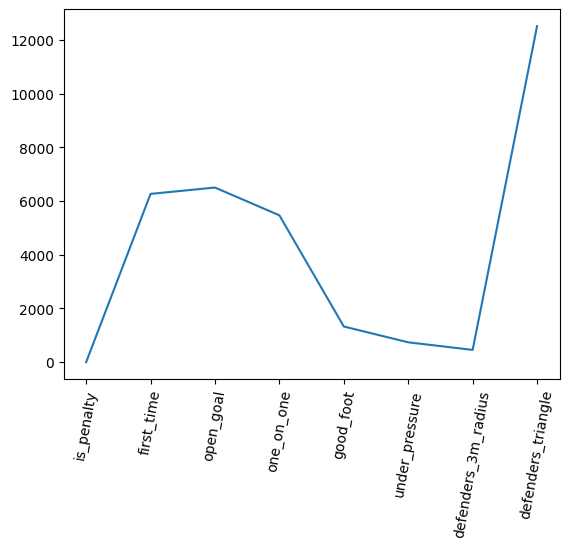

In [10]:
ax = pd.Series([x[1] for x in chi]).plot(xticks=pd.Series([x[0] for x in chi]).index, rot=80)
_ = ax.set_xticklabels(pd.Series([x[0] for x in chi]))

In [11]:
# Is the number of defenders in the triangle between the shooter and the goal significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['defenders_triangle'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 12518.92254395002
P-value: 0.0
Degrees of freedom: 11


In [12]:
# Is the shooter being on their favoured side significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['good_foot'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 1329.0532874858995
P-value: 5.490201091683067e-291
Degrees of freedom: 1


In [13]:
# Is the shooter being on their favoured side significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['was_leading'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 3823.2847825492354
P-value: 0.0
Degrees of freedom: 2


In [14]:
model = LinearRegression()
model.fit(pd.DataFrame(X_copy['distance_to_goalie']), y1)

# Print coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 0.20885919360308616
Coefficients: [-0.00687305]


In [15]:
results1 = smf.ols('is_goal ~ location_x + location_y + goalkeeper_x + goalkeeper_y', data=data).fit()
results2 = smf.ols('is_goal ~ distance_to_goalie + best_distance + location_x_distance', data=data).fit()
results3 = smf.ols('is_goal ~ defenders_triangle + defenders_3m_radius', data=data).fit()
results4 = smf.ols('is_goal ~ shooting_range + best_distance', data=data).fit()
results5 = smf.ols('is_goal ~ location_y_distance + good_foot', data=data).fit()
results6 = smf.ols('is_goal ~ distance_to_goalie + best_distance + defenders_triangle + shooting_range + is_header + under_pressure + play_pattern + technique', data=data).fit()

ValueError: endog has evaluated to an array with multiple columns that has shape (82713, 2). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [ ]:
stargazer_tab = Stargazer([results1, results2, results3, results4, results5, results6])
stargazer_tab

In [ ]:
results1 = smf.ols('location_x_distance ~ was_leading', data=data).fit()
results2 = smf.ols('best_distance ~ was_leading', data=data).fit()
results3 = smf.ols('location_x_distance ~ minute', data=data).fit()
results4 = smf.ols('best_distance ~ minute', data=data).fit()

In [ ]:
stargazer_tab = Stargazer([results1, results2, results3, results4])
stargazer_tab

In [ ]:
results1 = smf.ols('location_y_distance ~ was_leading', data=data).fit()
results2 = smf.ols('location_y_distance ~ minute', data=data).fit()

In [ ]:
stargazer_tab = Stargazer([results1, results2])
stargazer_tab